In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import polars.selectors as cs

In [2]:
# Load output
# Single agent output
# df = pl.read_json("../output_single.json").transpose()
# Multi-agent output
df = pl.read_json("../output_multi.json").transpose()

In [3]:
def add_repeat(df: pl.DataFrame) -> pl.DataFrame:
    return pl.concat(
        [
            df,
            pl.Series(
                np.tile(
                    np.arange(0, df.groupby("agent_id").count().max().to_numpy()[0, 1]),
                    df.select("agent_id").n_unique(),
                )
            )
            .rename("time")
            .to_frame(),
        ],
        how="horizontal",
    )


def process_raw_data(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df.transpose()
        .melt()
        .unnest("value")
        .explode("trajectory")
        .unnest("trajectory")
        .unnest("state")
        .unnest("reward")
        .select(
            (
                pl.col("variable")
                .str.split_exact(by="_", n=1)
                .struct.rename_fields(["1", "2"])
                .struct.field("2")
                .cast(pl.Int64)
                .alias("agent_id")
            ),
            pl.col("*").exclude(["variable", "val"]),
            pl.col("val").alias("reward"),
        )
    )


def add_dummies(df: pl.DataFrame) -> pl.DataFrame:
    # Adds OHE for action
    return pl.concat(
        [
            df.select(pl.all().exclude("action")),
            df.select(["action"])
            .to_dummies(columns=["action"], drop_first=False)
            .with_columns(
                cs.contains("action").map_alias(
                    lambda col_name: col_name.lstrip("action_")
                )
            )
            .select(pl.all().exclude("^action_.*$")),
        ],
        how="horizontal",
    )

In [4]:
# Process raw data, add time, add dummies for actions
df2 = add_dummies(add_repeat(process_raw_data(df)))

In [5]:
# Print head
df2.head()

agent_id,food,water,min_steps_to_food,min_steps_to_water,min_steps_to_trader,reward,time,Stationary,ToAgent,ToFood,ToWater
i64,i64,i64,i64,i64,i64,i64,i64,u8,u8,u8,u8
0,0,0,2,20,0,-2,0,0,1,0,0
0,30,-10,0,22,0,-11,1,0,0,0,1
0,30,-20,3,19,0,-21,2,0,0,0,1
0,20,-30,1,21,0,-31,3,0,0,0,1
0,50,-40,0,22,0,-41,4,0,0,0,1


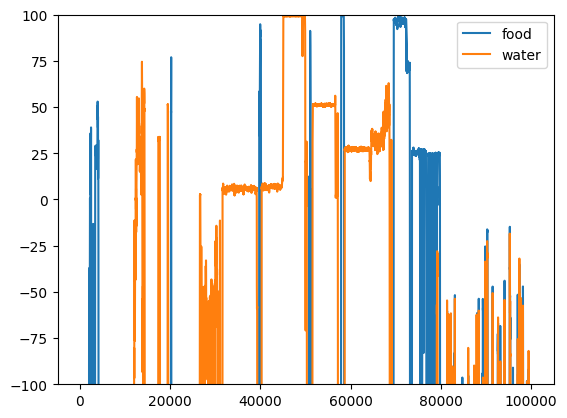

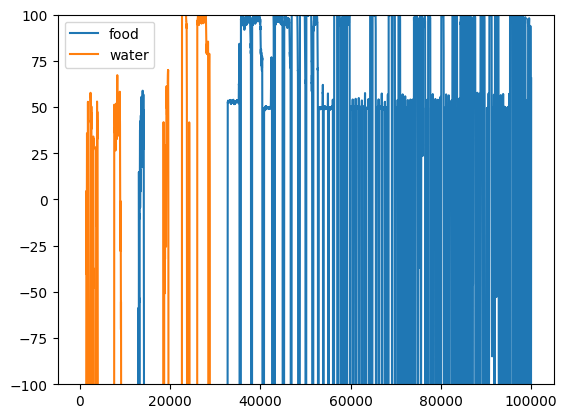

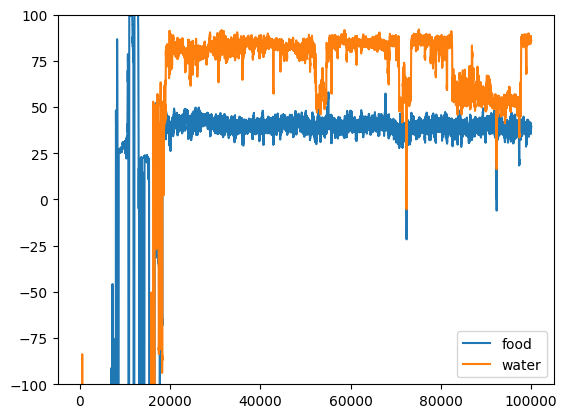

In [6]:
def plot_food_and_water(df: pl.DataFrame, agent_idx: int, window_size: int = 100):
    # Get smoothed versions
    av = (
        df.groupby(["agent_id"], maintain_order=True)
        .agg(
            [
                pl.col(["water", "food"]).rolling_mean(window_size=window_size),
            ]
        )
        .explode(["water", "food"])
    )
    plt.plot(
        av.filter(pl.col("agent_id") == agent_idx).select(["food", "water"]),
        label=["food", "water"],
    )
    plt.gca().set_ylim(-100, 100)
    plt.legend()


# Plot 3 agents
for i in range(0, 3):
    plot_food_and_water(df2, i)
    plt.show()

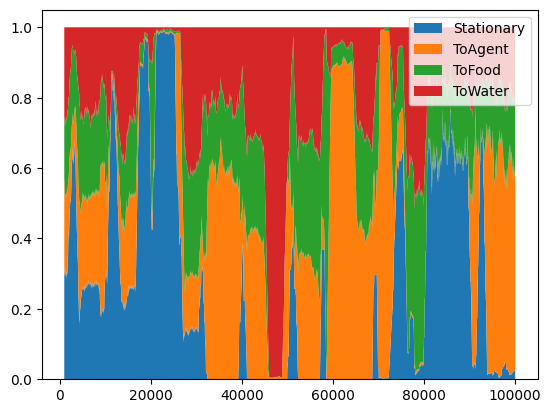

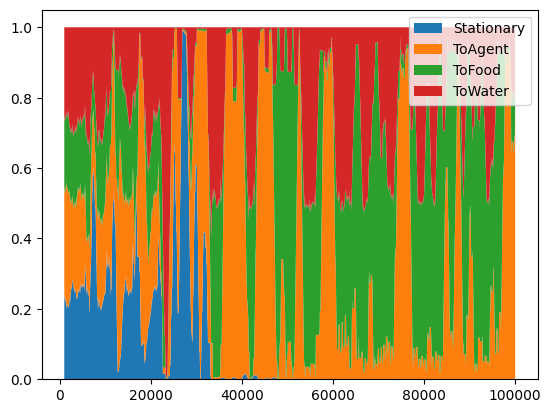

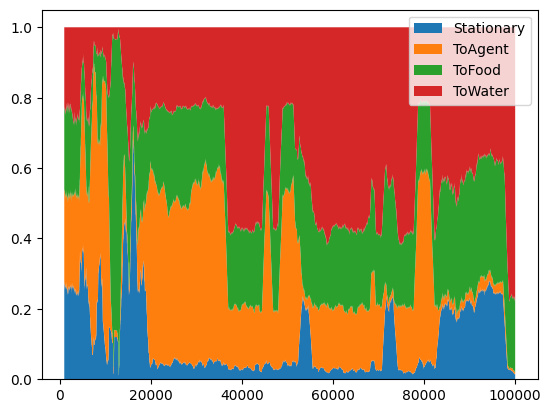

In [7]:
def plot_actions(df, agent_idx):
    acts = df.filter(pl.col("agent_id") == agent_idx).select(
        ["Stationary", "ToAgent", "ToFood", "ToWater"]
    )
    plt.stackplot(
        np.arange(acts.shape[0]),
        *acts.select(pl.col("*").rolling_mean(window_size=1000)).to_numpy().T,
        labels=acts.columns
    )
    plt.legend()
    plt.show()


# Plot 3 agents
for i in range(3):
    plot_actions(df2, i)